# Auto-Encoder Note v1

In [4]:
# import watermark
%reload_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.6.6
IPython 6.5.0

numpy 1.14.5
sklearn 0.20.0
scipy 1.1.0
matplotlib 3.0.0
tensorflow 1.10.1


In [32]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import sys
import os

# Custom Modules
import EGJ.utils as utils

# 맷플롯립 설정
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 파일 저장 로드 등에 사용
ROOT_PATH = os.getcwd() + "/EGJ/Autoencoder"

# PCA; 주성분 분석

<br/>MLP 와 동일한 코드로 작성
<br/>출력의 갯수 = 입력의 갯수
<br/>활성함수 사용하지 않음; 모든 뉴런이 선형
<br/>비용함수는 MSE

In [33]:
# 3D 데이터셋을 만듭니다
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [34]:
# 데이터 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [35]:
# 오토인코더 생성
import tensorflow as tf

# EGJ.utils
utils.reset_graph()

n_inputs = 3
n_hidden = 2  # 코딩 유닛
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [36]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

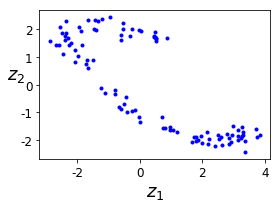

In [37]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
# EGJ.utils
utils.save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Auto-Encoder Example (= Deep Auto-Encoder); 적층 오토인코더

<br/>Deep MLP 과 비슷하게 구현 가능
<br/>example code = MNIST; Modified National Institute of Standards and Technology database

In [38]:
# 데이터 생성
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

## 적용할 인코더 스팩

<br/>은닉층(3개) + 출력층 => 2개의 적층
<br/>활성화 함수 = ELU
<br/>초기화 = He
<br/>정규화 = L2

In [39]:
# 일관된 출력을 위해 유사난수 초기화
utils.reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hiddens = [300, 150, 300]
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.variance_scaling_initializer() # He 초기화
# == he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hiddens[0])
hidden2 = my_dense_layer(hidden1, n_hiddens[1])
hidden3 = my_dense_layer(hidden2, n_hiddens[2])
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [56]:
# 비지도 학습
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            # EGJ.utils
            X_batch, y_batch = next(utils.shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
            
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)

        # EGJ.utils
        utils.save_tf(sess, "note/stack/model", root_path=ROOT_PATH)

0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 훈련 MSE: 0.017882433


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 훈련 MSE: 0.018124273


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 훈련 MSE: 0.01798426


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 훈련 MSE: 0.018740688


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

4 훈련 MSE: 0.018716121


In [70]:
# 모델을 로드하고 테스트 세트에서 이를 평가; 재구성 오차를 측정; 재구성 이미지 드로잉
def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            # EGJ.utils
            utils.load_tf(sess, model_path, root_path=ROOT_PATH)
            
        # outputs_val
        outputs.eval(feed_dict={X: X_test[:n_test_digits]})

    # fig
    plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        # EGJ.utils
        utils.plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        # EGJ.utils
        utils.plot_image(X_test[digit_index])

INFO:tensorflow:Restoring parameters from /Users/eugene/Projects/DAEGUML/EGJ/Autoencoder/outputs/tf_sess/note/stack/model.ckpt


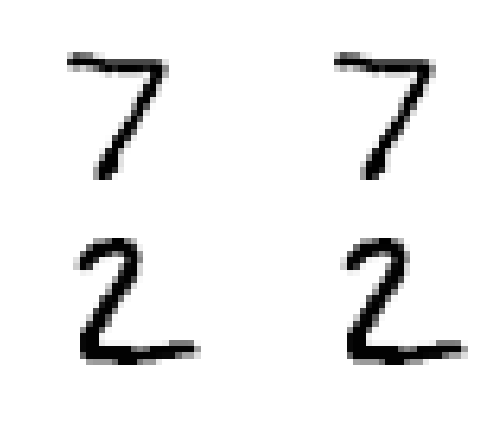

In [57]:
show_reconstructed_digits(X, outputs, "note/stack/model")
utils.save_fig("note_stack_reconstruction_plot", root_path=ROOT_PATH)

## 가중치 묶기

<br/>오토인코더가 완벽하게 대칭일 때, 디코더의 가중치와 인코더의 가중치를 묶음
<br/>=> 모델에 있는 가중치의 수를 절반으로 줄여서 훈련 속도를 높이고 과적합을 방지하는데 도움이 됨
<br/>
<br/>예시)
<br/>적층수: N 개
<br/>L 번째 층의 가중치: W|L
<br/>첫 번째 은닉층: 1
<br/>코딩층: N/2
<br/>출력층: N
<br/>
<br/>=>디코더 가중치 = W|N-L+1 = W|L^T 

In [59]:
# 유사난수 초기화
utils.reset_graph()

n_inputs = 28 * 28
n_hiddens = [300, 150, 300]
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [61]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hiddens[0]])
weights2_init = initializer([n_hiddens[0], n_hiddens[1]])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
# 변수 아님(X); weight1,2 의 전치 == 묶여있음 => L2 정규화를 하지 않음
weights3 = tf.transpose(weights2, name="weights3")  # 가중치 묶기
weights4 = tf.transpose(weights1, name="weights4")  # 가중치 묶기

# biases; 편향은 묶지 않고도 정규화를 하지 않음
biases1 = tf.Variable(tf.zeros(n_hiddens[0]), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hiddens[1]), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hiddens[2]), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [62]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            # EGJ.utils
            X_batch, y_batch = next(utils.shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
            
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        # EGJ.utils
        utils.save_tf(sess, "note/stack_weights/model", root_path=ROOT_PATH)

0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 훈련 MSE: 0.018894535


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 훈련 MSE: 0.01686014


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 훈련 MSE: 0.018383685


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 훈련 MSE: 0.01832356


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

4 훈련 MSE: 0.017886007


INFO:tensorflow:Restoring parameters from /Users/eugene/Projects/DAEGUML/EGJ/Autoencoder/outputs/tf_sess/note/stack_weights/model.ckpt


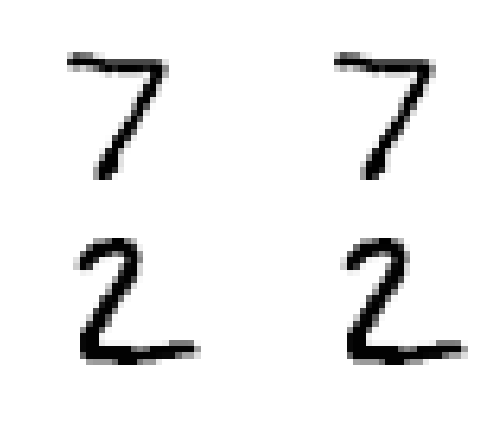

In [63]:
show_reconstructed_digits(X, outputs, "note/stack_weights/model")
utils.save_fig("note_stack_weights_reconstruction_plot", root_path=ROOT_PATH)

## 여러 개의 그래프에서 오토인토더를 따로따로 훈련하기; 한 번에 한 층씩 훈련

<br/>[하나의 오토인코더를 따로따로 훈련하는 방법]
<br/>
<br/>방법 1. 각 오토인코더를 다른 그래프로 훈련하여 나온 가중치와 편향을 복사해 초깃값으로 지정해서 적층 오토인코더를 만드는 것

In [65]:
# 하나의 오토인코더로 훈련하여 변환된 은닉층/출력층과 모델 파라미터를 반환하는 함수
# EGJ.utils
utils.reset_graph()

from functools import partial


def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    
    graph = tf.Graph()
    
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()
    
    with tf.Session(graph=graph) as sess:
        init.run()
        
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
                
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
            
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [66]:
# 두 개의 오토인코더를 훈련; [1]번은 훈련 데이터를 사용, [2]번은 [1]번 오토인코더의 은닉층 출력을 사용 
hidden_output, W1, b1, W4, b4 = train_autoencoder(X_train, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 훈련 MSE: 0.018396776
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 훈련 MSE: 0.017695026
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 훈련 MSE: 0.019602837
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 훈련 MSE: 0.019349463


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 훈련 MSE: 0.004570484
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 훈련 MSE: 0.004802369
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 훈련 MSE: 0.00477468
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 훈련 MSE: 0.004450083


In [72]:
# 훈련한 오토인코더 [1], [2]의 가중치와 편향을 재사용하여 적층 오토인코더 생성
utils.reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

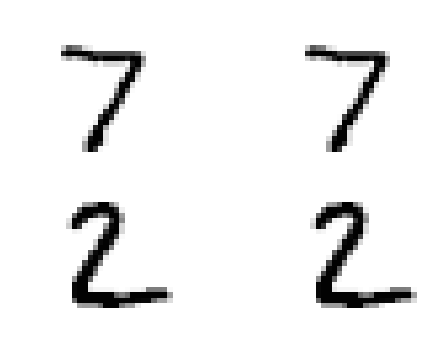

In [74]:
show_reconstructed_digits(X, outputs)

## 하나의 그래프에서 오토인코더를 따로따로 훈련하기

<br/>[하나의 오토인코더를 따로따로 훈련하는 방법]
<br/>
<br/>방법 2. 각 오토인코더를 독립적으로 훈련; 단계별로 따로 훈련
<br/> - 1 단계: 첫 번째와 마지막 층을 훈련; [1]번 오토인코더
<br/> - 2 단계: 가운대 층을 훈련; [2]번 오토인코더

In [77]:
# EGJ.utils
utils.reset_graph()

# 보통처럼 적층 오토인코더 생성
n_inputs = 28 * 28
n_hiddens = [300, 150, 300]
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hiddens[0]])
weights2_init = initializer([n_hiddens[0], n_hiddens[1]])
weights3_init = initializer([n_hiddens[1], n_hiddens[2]])
weights4_init = initializer([n_hiddens[2], n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hiddens[0]), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hiddens[1]), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hiddens[2]), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [80]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    # 첫 번째 은닉층을 제외한 나머지는 통과 (무시; 패스)
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    # 첫 번째 은닉층 동결
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars)
    
init = tf.global_variables_initializer()

In [81]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    
    for phase in range(2):
        print("훈련 단계 #{}".format(phase + 1))
        
        for epoch in range(n_epochs[phase]):
            n_batches = len(X_train) // batch_sizes[phase]
            
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                # EGJ.utils
                X_batch, y_batch = next(utils.shuffle_batch(X_train, y_train, batch_sizes[phase]))
                sess.run(training_ops[phase], feed_dict={X: X_batch})
                
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
            # EGJ.utils
            utils.save_tf(sess, "note/stack_weights_each/model", root_path=ROOT_PATH)
            
    loss_test = reconstruction_loss.eval(feed_dict={X: X_test})
    print("테스트 MSE:", loss_test)

훈련 단계 #1
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 훈련 MSE: 0.00793276


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 훈련 MSE: 0.0073405313


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 훈련 MSE: 0.007749653


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 훈련 MSE: 0.0077196048


훈련 단계 #2
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 훈련 MSE: 0.17245102


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 훈련 MSE: 0.005785428


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 훈련 MSE: 0.0030174518


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 훈련 MSE: 0.0023449059


테스트 MSE: 0.009837554


In [83]:
# 동결층(첫 번째 은닉층) 출력을 캐싱
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    
    for phase in range(2):
        print("훈련 단계 #{}".format(phase + 1))
        
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: X_train})
            
        for epoch in range(n_epochs[phase]):
            n_batches = len(X_train) // batch_sizes[phase]
            
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                
                if phase == 1:
                    indices = rnd.permutation(len(X_train))
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    # EGJ.utils
                    X_batch, y_batch = next(utils.shuffle_batch(X_train, y_train, batch_sizes[phase]))
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                    
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
            # EGJ.utils
            utils.save_tf(sess, "note/stack_weights_each/model_cached_frozen", root_path=ROOT_PATH)
            
    loss_test = reconstruction_loss.eval(feed_dict={X: X_test})
    print("테스트 MSE:", loss_test)

훈련 단계 #1
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 훈련 MSE: 0.007972069


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 훈련 MSE: 0.0071744528


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 훈련 MSE: 0.007869386


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 훈련 MSE: 0.008077211


훈련 단계 #2


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 훈련 MSE: 0.23443758


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 훈련 MSE: 0.005739137


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 훈련 MSE: 0.0031680698


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 훈련 MSE: 0.0023631211


테스트 MSE: 0.009901792


INFO:tensorflow:Restoring parameters from /Users/eugene/Projects/DAEGUML/EGJ/Autoencoder/outputs/tf_sess/note/stack_weights_each/model_cached_frozen.ckpt


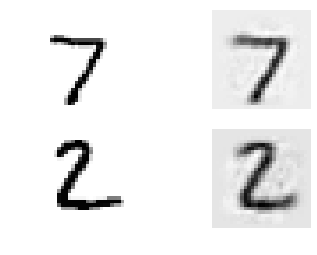

In [84]:
# 재구성 시각화; 오토인코더가 제대로 훈련되었는지 확인 => 입력과 출력 비교
n_test_digits = 2
# X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    # EGJ.utils
    utils.load_tf(sess, "note/stack_weights_each/model_cached_frozen", root_path=ROOT_PATH)
    outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    # EGJ.utils
    utils.plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    # EGJ.utils
    utils.plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from /Users/eugene/Projects/DAEGUML/EGJ/Autoencoder/outputs/tf_sess/note/stack_weights_each/model_cached_frozen.ckpt


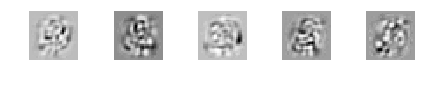

In [85]:
# 특성 시각화; 오토인코더가 어떤 특성을 학습했는지 확인
# 방법 1. 은닉층에 있는 각 뉴런을 가장 크게 활성화시키는 훈련샘플을 찾아서 확인 가능; 최상단 은닉층에 유용; BUT! 하위층은 특성의 크기가 작고 추상적이이라면 특성 찾기가 힘듬
# 방법 2. 첫 번째 은닉층에 있는 각 뉴런에 연결된 가중치를 이용해서 이미지를 생성 가능
with tf.Session() as sess:
    # EGJ.utils
    utils.load_tf(sess, "note/stack_weights_each/model_cached_frozen", root_path=ROOT_PATH)
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    # EGJ.utils
    utils.plot_image(weights1_val.T[i])

# EGJ.utils
utils.save_fig("note_stack_weights_each_model_cached_frozen_extracted_features_plot")
plt.show()